In [ ]:
import pandas as pd
import requests

# Setup
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
email = "mheat21@byu.edu"
ua = f"STAT386-class-scraper/1.0 (+{email})"

r = requests.get(url, headers={"User-Agent": ua, "From": email}, timeout=15)
r.raise_for_status()

tables = pd.read_html(r.text)

wiki_df = tables[0]

# Keep and rename key columns
wiki_df = wiki_df[['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry']]
wiki_df.columns = ['Ticker', 'Company', 'Sector', 'SubIndustry']

# Use Wikipedia df and fix mismatched tickers
tickers = wiki_df['Ticker'].replace({'BRK.B': 'BRK-B', 'BF.B': 'BF-B'}).tolist()

print(wiki_df.shape)
print(wiki_df.head())


(503, 4)
  Ticker              Company                  Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                      SubIndustry  
0        Industrial Conglomerates  
1               Building Products  
2           Health Care Equipment  
3                   Biotechnology  
4  IT Consulting & Other Services  


/var/folders/l9/dtywcq4x0_n3zd8mjfr26ttm0000gn/T/ipykernel_27067/641208208.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(r.text)


In [ ]:
import yfinance as yf
from datetime import datetime, timedelta

# Download last year's worth of data
end = datetime.today()
start = end - timedelta(days=365)
data = yf.download(tickers, start=start, end=end, group_by='ticker', progress=False)


/var/folders/l9/dtywcq4x0_n3zd8mjfr26ttm0000gn/T/ipykernel_27067/2796067995.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end, group_by='ticker', progress=False)


In [ ]:
# Flatten data structure
data_flat = pd.DataFrame()
for ticker in tickers:
    if ticker in data:
        df = data[ticker].copy()
        df.columns = [f"{ticker}_{col}" for col in df.columns]
    if data_flat.empty:
        data_flat = df
    else:
        data_flat = pd.concat([data_flat, df], axis=1)
else:
    print(f"No data for {ticker}")

No data for ZTS


In [ ]:
# Calculate performance metrics
metrics = []

for ticker in tickers:
    col_name = f"{ticker}_Close"
    if col_name in data_flat:
        close = data_flat[col_name]
        daily_return = close.pct_change()
        pct_change_1y = (close.iloc[-1] - close.iloc[0]) / close.iloc[0] * 100
        volatility = daily_return.std() * (252 ** 0.5) * 100
        avg_return = daily_return.mean() * 252 * 100
        max_drawdown = ((close.cummax() - close) / close.cummax()).max() * 100

        metrics.append({
            'Ticker': ticker,
            '1Y_Change(%)': pct_change_1y,
            'Volatility(%)': volatility,
            'AvgAnnualReturn(%)': avg_return,
            'MaxDrawdown(%)': max_drawdown
        })
else:
    print(f"Data missing for {ticker}")

perf_df = pd.DataFrame(metrics)

Data missing for ZTS


In [ ]:
# Merge with Wikipedia data
merged_df = wiki_df.merge(perf_df, on='Ticker', how='left')
print(merged_df.head())

  Ticker              Company                  Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                      SubIndustry  1Y_Change(%)  Volatility(%)  \
0        Industrial Conglomerates     25.582990      29.673522   
1               Building Products    -11.969194      24.454848   
2           Health Care Equipment     10.422882      21.452919   
3                   Biotechnology     13.061136      28.846938   
4  IT Consulting & Other Services    -32.137831      28.279164   

   AvgAnnualReturn(%)  MaxDrawdown(%)  
0           27.528418       18.714543  
1           -9.969601       21.172245  
2           12.389165       13.270805  
3           16.711912       20.736387  
4          -35.357239       41.021444  


In [ ]:
# Drop rows where we didn’t get Yahoo data
clean_df = merged_df.dropna(subset=['1Y_Change(%)'])

# Sort by 1-year percent change descending
merged_df = clean_df.sort_values(
    by=['1Y_Change(%)', 'AvgAnnualReturn(%)'], ascending=[False, False]
)

# Check the top 10
print(merged_df.head(10))

    Ticker                 Company                  Sector  \
398   HOOD       Robinhood Markets              Financials   
357   PLTR   Palantir Technologies  Information Technology   
490    WDC         Western Digital  Information Technology   
408    STX      Seagate Technology  Information Technology   
40     APP                AppLovin  Information Technology   
483    WBD  Warner Bros. Discovery  Communication Services   
313     MU       Micron Technology  Information Technology   
280   LRCX            Lam Research  Information Technology   
72    AVGO                Broadcom  Information Technology   
434    TPR          Tapestry, Inc.  Consumer Discretionary   

                                    SubIndustry  1Y_Change(%)  Volatility(%)  \
398              Investment Banking & Brokerage    332.833785      74.579773   
357                        Application Software    213.260558      68.823068   
490  Technology Hardware, Storage & Peripherals    208.203474      52.523962 

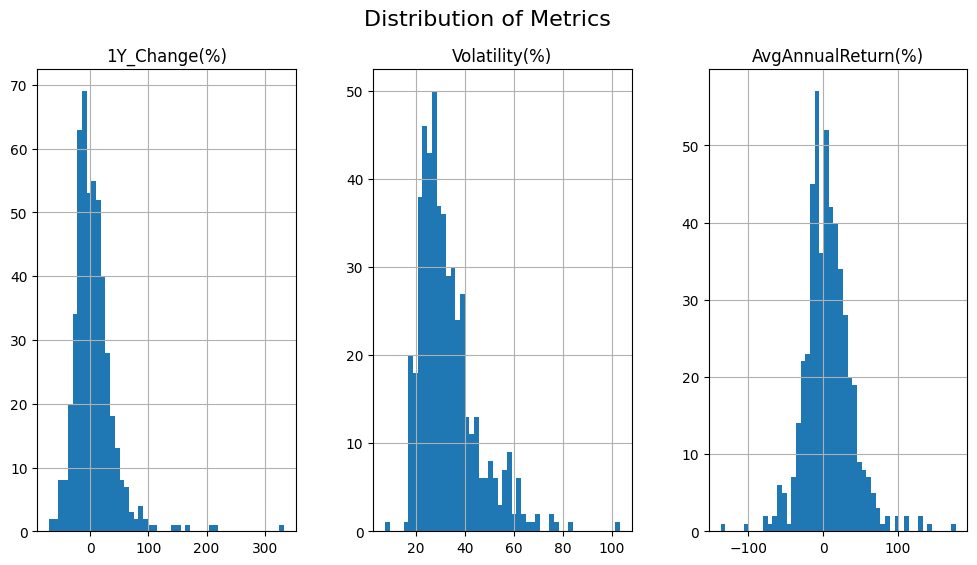

In [8]:
# EDA 
import matplotlib.pyplot as plt

# Plot histogram for selected columns
cols_to_plot = ['1Y_Change(%)', 'Volatility(%)', 'AvgAnnualReturn(%)']
merged_df[cols_to_plot].hist(bins=50, figsize=(12,6), layout=(1,3))
plt.suptitle('Distribution of Metrics', fontsize=16)
plt.show()

In [9]:
merged_df.describe()

,1Y_Change(%),Volatility(%),AvgAnnualReturn(%),MaxDrawdown(%)
count,499.000000,501.000000,501.000000,501.000000
mean,5.774609,33.008370,6.763807,28.445721
std,35.895201,11.946747,31.842728,11.609342
min,-70.493607,7.263224,-136.461271,5.810692
25%,-15.203975,24.591070,-11.915824,20.455792
50%,0.907385,30.101173,4.826374,27.327944
75%,21.250825,38.249707,23.879211,35.064664
max,332.833785,103.223698,176.781013,74.082172


<Axes: xlabel='Volatility(%)', ylabel='1Y_Change(%)'>

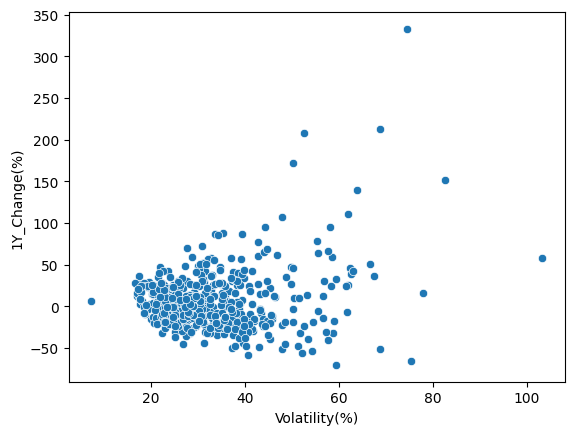

In [10]:
import seaborn as sns
sns.scatterplot(data=merged_df, x='Volatility(%)', y='1Y_Change(%)')

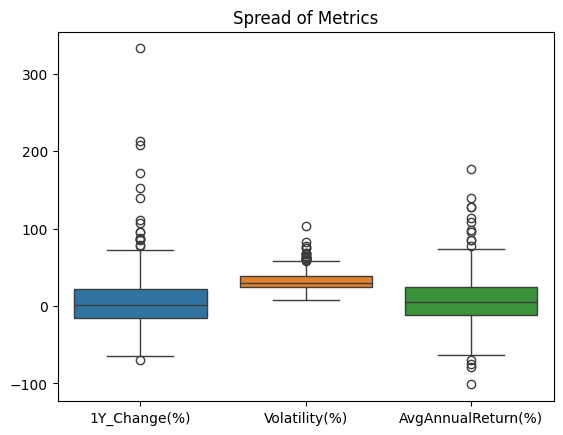

In [16]:
sns.boxplot(data=merged_df[cols_to_plot])
plt.title("Spread of Metrics")
plt.show()

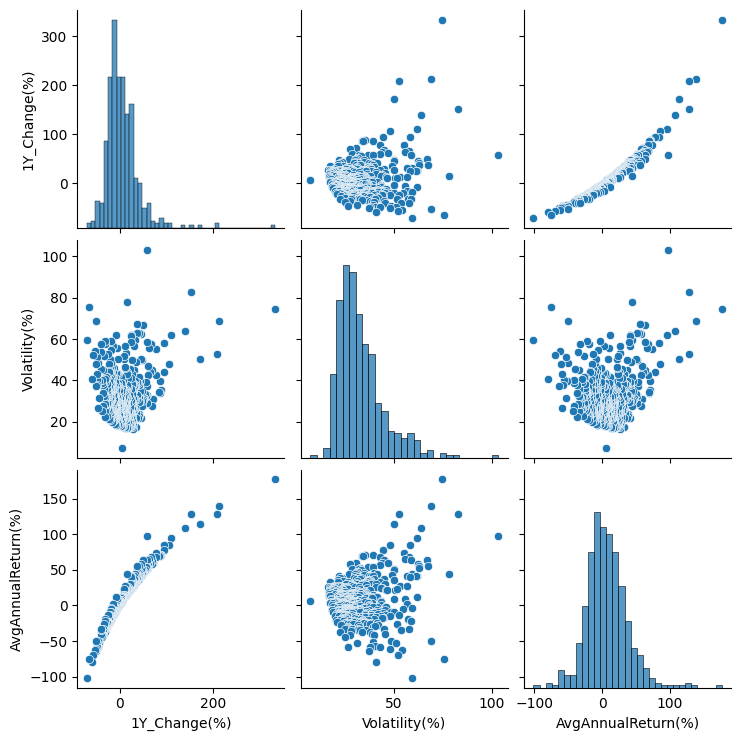

In [17]:
sns.pairplot(merged_df[cols_to_plot])

In [21]:
sector_summary = merged_df.groupby("Sector")["1Y_Change(%)"].mean().sort_values(ascending=False)
print(sector_summary)


Sector
Information Technology    22.478669
Utilities                 18.332532
Communication Services    15.622201
Financials                 8.306819
Consumer Discretionary     5.085562
Industrials                4.384726
Energy                     0.708936
Health Care               -2.390586
Consumer Staples          -5.333184
Real Estate               -7.414576
Materials                -10.034650
Name: 1Y_Change(%), dtype: float64


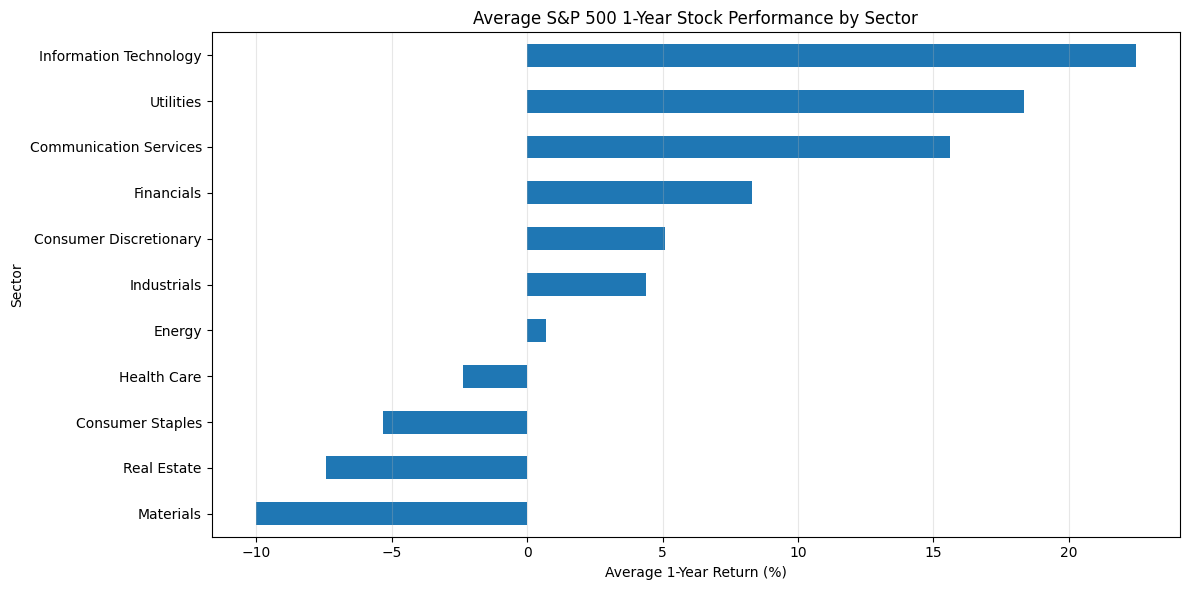

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
merged_df.groupby("Sector")["1Y_Change(%)"].mean().sort_values().plot(kind="barh")

plt.xlabel("Average 1-Year Return (%)")
plt.title("Average S&P 500 1-Year Stock Performance by Sector")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [19]:
merged_df_sorted = merged_df.sort_values(by='1Y_Change(%)', ascending=False)
print("Top 10 performers:\n", merged_df_sorted[['Ticker','1Y_Change(%)']].head(10))
print("\nBottom 10 performers:\n", merged_df_sorted[['Ticker','1Y_Change(%)']].tail(10))


Top 10 performers:
     Ticker  1Y_Change(%)
398   HOOD    332.833785
357   PLTR    213.260558
490    WDC    208.203474
408    STX    171.367394
40     APP    152.042343
483    WBD    139.274283
313     MU    111.026415
280   LRCX    106.928563
72    AVGO     95.352553
434    TPR     95.169433

Bottom 10 performers:
     Ticker  1Y_Change(%)
293   LULU    -48.128763
58     BAX    -48.974941
14     ARE    -50.283733
153    DOW    -51.111823
316   MRNA    -51.610977
139   DECK    -53.420101
318    MOH    -56.433417
205     IT    -58.124826
447    TTD    -65.366331
196     FI    -70.493607


In [13]:
merged_df.to_csv("sp500_merged.csv", index=False)